<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Save, compress, and deploy a handwritten digit prediction Keras model</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to train, deploy, and score a Deep Learning model using the Watson Machine Learning service.

This notebook specifically shows how to save the trained Deep Learning model as a `.tgz` file locally and deploy the model - the `.tgz` file - online. 

Some familiarity with Python is helpful. This notebook is compatible with Python 3.6 and uses `keras 2.2.5` and <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

- Set up Watson Machine Learning service that can be used to deploy/score online a Deep Learning (Keras) model.
- Build a Deep Learning (Keras) model and train it.
- Save the trained model - `.tgz` file - in the Watson Machine Learning repository.
- Deploy the trained model online and score it.


## Contents

1.	[Set up the environment](#setup)
2.	[Explore data](#data)
3.  [Train/evaluate the model](#train)
4.	[Save the model locally](#save)
5.	[Create an online deployment](#deploy)
6.	[Score data](#score)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before running the code in this notebook, make sure you meet the following prerequisites:

-  A <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance is installed (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>.

-  Local python environment configurations:
  + Python 3.6
  + keras 2.2.5
  + watson-machine-learning-client (run code below to install it)
  + matplotlib

**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.  
**Tip:** Run the cell below to install `watson-machine-learning-client` package from <a href="https://pypi.python.org/pypi" target="_blank" rel="noopener no referrer">PyPI</a>.

In [79]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [80]:
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.378)


**Authenticate the Watson Machine Learning service on the IBM Cloud.**

**Tip**: Authentication information (your credentials) can be found in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener no referrer">Service credentials</a> tab of the service instance that you created on the IBM Cloud. <BR>If you cannot find the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your WML service instance credentials in the following cell.

In [81]:
wml_credentials = {
    'apikey': "t5EyffiG3g6tja7PXPo6k_d0lE6SIeU0btiM6YCtSteV",
    'url': "https://us-south.ml.cloud.ibm.com",
    'instance_id': "31d33010-155d-481f-884e-2f7fab1293e7"
}

#### Import `watson-machine-learning-client` and authenticate the service instance.

In [82]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [83]:
client = WatsonMachineLearningAPIClient(wml_credentials)

## 2. Explore data <a id="data"></a>

In this section, you will check what the input data looks like.
You need `keras.datasets.mnist` and `matplotlib.pyplot` modules to see what each digit looks like.

Import the MNIST data set from the `keras.datasets.mnist` module and split the data set into training and test data sets.

In [84]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [85]:
!pip install --upgrade keras==2.2.5

Requirement already up-to-date: keras==2.2.5 in /opt/conda/envs/Python36/lib/python3.6/site-packages (2.2.5)


In [86]:
import keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Import `matlplotlib.pyplot`.

In [87]:
import matplotlib.pyplot as plt

In [88]:
'''
Paramters of "display_digits" function:

plt     - matplotlib's pyplot module.
images  - The array of images. Ex) X_train, X_test in our example
labels  - Labels of mapping images. 
start   - Start index of "images" array.
end     - End index of "images" array.
num_row - Number of rows.
title   - Title of every image that will be displayed. Ex) Training or Test
'''
def display_digits(plt, images, labels, start, end, num_row, title):
    images_and_labels = list(zip(images, labels))
    num_col = int(end/num_row) if (end % 2 == 0) else int(end/num_row) + 1

    for index, (image, label) in enumerate(images_and_labels[start:end]):
        plt.subplot(num_row, num_col, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title + ': %i' % label)

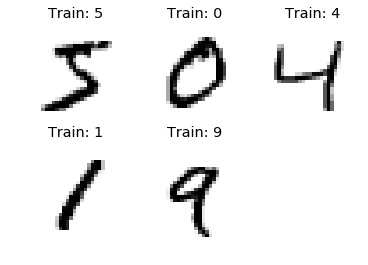

In [89]:
display_digits(plt, X_train, y_train, 0, 5, 2, 'Train')

Training and test data sets shape and correponding label arrays.

In [90]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Save copies of `X_test` and `y_test` for scoring in section [6. Score](#score) before reshaping them in section [3.1 Train the model](#train_sub).

In [91]:
X_test_score = X_test.copy()
y_test_score = y_test.copy()

## 3. Train and evaluate the model <a id="train"></a>

In this section, you will build a Deep Learning (Keras) model, train it, and evaluate it.

Import the required package and modules.

In [92]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### 3.1 Train the model <a id="train_sub"></a>

Set the parameters that are required for the Deep Learning (Keras) model.

In [93]:
batch_size = 128
num_classes = 10
epochs = 6

As you have seen in section [2. Explore data](#data), the image size is 28x28 pixels.

In [94]:
img_rows, img_cols = 28, 28

In [95]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Scale the digits to be in the range of [0-1] instead of [0-255].

In [96]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Convert the label arrays of training/test digit images into one hot format matrix.

Ex)  
0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1 => [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
.  
.  
.  

In [97]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

- Conv2D layer
    - The first 2D convolution layer has 32 output filters and the second 2D convolution layer has 64 output filters.
    - `kernel_size` specifies the height and width of the 2D convolution window.
    - `activation` is a non-linear function that applies to the output of the layer. `relu` (rectified linear unit) clamps all values below 0 to 0.
- MaxPooling layer
    - Max pooling basically moves a `m`x`n` window across a 2D input space where `m` and `n` are both 2 in this example. The max value within the window is the output.
- Dropout layer
    - Helps the model to avoid overfitting.
- Dense layer
    - A regular densely-connected Neural Network layer.
- Flatten layer
    - Flattens the input and doesn't affect the batch size.
- Adadelta 
    - Adapts learning rates based on a moving window of gradient updates instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates occur.

In [98]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Train the model with the parameters you set before.

In [99]:
history = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 423s 7ms/step - loss: 0.2598 - acc: 0.9193 - val_loss: 0.0531 - val_acc: 0.9832
Epoch 2/6
60000/60000 [==============================] - 506s 8ms/step - loss: 0.0886 - acc: 0.9736 - val_loss: 0.0398 - val_acc: 0.9873
Epoch 3/6
60000/60000 [==============================] - 496s 8ms/step - loss: 0.0640 - acc: 0.9809 - val_loss: 0.0340 - val_acc: 0.9883
Epoch 4/6
60000/60000 [==============================] - 494s 8ms/step - loss: 0.0535 - acc: 0.9840 - val_loss: 0.0318 - val_acc: 0.9891
Epoch 5/6
60000/60000 [==============================] - 478s 8ms/step - loss: 0.0473 - acc: 0.9860 - val_loss: 0.0305 - val_acc: 0.9896
Epoch 6/6
60000/60000 [==============================] - 588s 10ms/step - loss: 0.0417 - acc: 0.9873 - val_loss: 0.0261 - val_acc: 0.9907


Let's plot the model accuracy on the train and validation (test) data sets. You will plot the graphs in `R`'s `ggplot` style.

In [100]:
plt.style.use('ggplot')

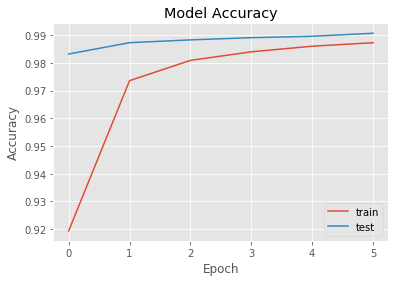

In [101]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

Let's plot the model loss on the train and validation (test) data sets.

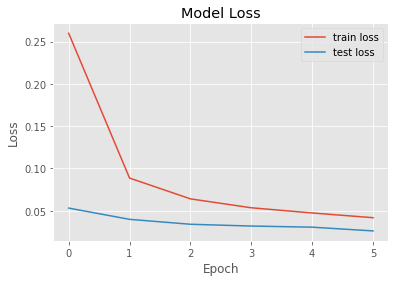

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')

### 3.2 Evaluate the model

Let's evaluate the model.

In [103]:
score = model.evaluate(X_test, y_test, verbose=0)

In [104]:
print('Test loss:', score[0])
print('Test accuracy: {:.2f}%'.format(score[1]*100))

Test loss: 0.02609239214255067
Test accuracy: 99.07%


## 4. Save the model locally <a id="save"></a>

In this section, you will learn how to save the train Deep Learning (Keras) model locally and compress it into a `.tgz` file.

First, save the Keras model locally.

In [105]:
from contextlib import suppress
import os

filename = 'keras_mnist_model.h5'

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

Compress the Keras model file into a `.tgz` file. Make sure to add the `z` flag when running the `tar` command.

In [106]:
#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
os.system(cmdstring)

0

You can see that the model file (keras_mnist_model.h5) and its compressed version (keras_mnist_model.h5.tgz) are both saved in the local file system.

In [107]:
!ls

keras_mnist_model.h5  keras_mnist_model.h5.tgz


## 5. Create an online deployment <a id="deploy"></a>

In this section, you learn how to deploy the compressed version - the `.tgz` file - of the trained model described in section [4. Save the model locally](#save) online.

First, let's instantiate a `WatsonMachineLearningAPIClient` object with your WML credentials.

In [108]:
client = WatsonMachineLearningAPIClient(wml_credentials)

Define metadata for the trained model in section [3. Train and evaluate the model](#train).

In [109]:
model_props = {
    client.repository.ModelMetaNames.NAME: 'MNIST - compressed keras model',
    client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.15',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6',
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.5'}]
}

published_model_details = client.repository.store_model(model=tar_filename, meta_props=model_props)       

Get the `uid` for the trained model.

In [110]:
model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

5ac69847-ddb3-471f-b211-cb15d70eeb01


You can deploy the stored model as a web service (online) by running the following code.

In [111]:
deployment = client.deployments.create(model_uid, 'Keras MNIST model deployment through compressed file.')



#######################################################################################

Synchronous deployment creation for uid: '5ac69847-ddb3-471f-b211-cb15d70eeb01' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8f7b94ae-5c49-4ec7-be31-cac2f9938c5e'
------------------------------------------------------------------------------------------------




Let's list the deployed models.

In [112]:
client.deployments.list()

------------------------------------  -----------------------------------------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                                                   TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
8f7b94ae-5c49-4ec7-be31-cac2f9938c5e  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-04T11:38:34.047Z  tensorflow-1.15  model
ea215c2c-df86-42bb-92dd-0b3b805dcfd0  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-04T10:42:15.266Z  tensorflow-1.15  model
7235a1e7-a9ef-44f4-b3ca-f9621684b821  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-04T10:28:50.170Z  tensorflow-1.15  model
48d887e5-68d5-447a-93f9-c3ecac236b1d  Keras MNIST model deployment through compressed file.  online  DEPLOY_SUCCESS  2020-06-04T09:53:50.504Z  tensorflow-

## 6. Score data <a id="score"></a>

In this section, you will learn how to score a test data record.

First, extract the scoring endpoint from the deployment details.

In [113]:
scoring_endpoint = client.deployments.get_scoring_url(deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/31d33010-155d-481f-884e-2f7fab1293e7/deployments/8f7b94ae-5c49-4ec7-be31-cac2f9938c5e/online


The first digit of `X_test` will be used for scoring.

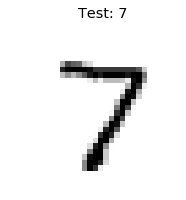

In [114]:
scoring_data = X_test[0].tolist()
display_digits(plt, X_test_score, y_test_score, 0, 1, 1, 'Test')

Map keys - 'fields' and 'values' - to their corresponding values in the `scoring payload` dictionary and score the model. However, only 'values' will be used in this example - map 'values' to `scoring_data` in the `scoring payload` dictionary .

In [115]:
scoring_payload = {'values': [scoring_data]}
scores = client.deployments.score(scoring_endpoint, scoring_payload)

In [116]:
print(str(scores))

{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[1.0673347622391915e-11, 1.384352743549755e-09, 1.735937793512221e-08, 2.112872721227177e-08, 2.6645938233649247e-10, 1.7174518101084613e-12, 9.150164045239936e-15, 1.0, 2.1158952367983375e-10, 2.1156310481273977e-08], 7, [1.0673347622391915e-11, 1.384352743549755e-09, 1.735937793512221e-08, 2.112872721227177e-08, 2.6645938233649247e-10, 1.7174518101084613e-12, 9.150164045239936e-15, 1.0, 2.1158952367983375e-10, 2.1156310481273977e-08]]]}


As you can see in the following cell, the predicted label (`prediction_classes`) in the result of the above cell) and the true label are the same - `7`.

## 7. Summary and next steps <a id="summary"></a>

You successfully completed this notebook! 
 
You learned how to train, evaluate, and score a Keras model. You also learned how to deploy the model in a `.tgz` format via `watson-machine-learning-client` package.
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

### Author

**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

<hr>
Copyright © 2019, 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>